# Quantum Algorithms

In [133]:
from openql import openql as ql
import qxelarator
import random
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt


In [134]:
ql.initialize()
compiler = ql.Compiler("compiler", "./compiler-config.json")

platform = ql.Platform("platform", "none")
platform.set_compiler(compiler=compiler)


def simulate(*, program, measured=None, shots):
    qx = qxelarator.QX()
    qx.set(f"output/{program.name}.qasm")

    qubits = measured if measured else range(program.qubit_count)

    counts = defaultdict(int)
    for _ in range(shots):
        qx.execute()
        result = [int(qx.get_measurement_outcome(qubit)) for qubit in qubits]
        result = reduce(lambda x, y: x + str(y), result, "")
        counts[result] += 1

    return dict(counts)


def plot_histogram(counts, **kwargs):
    total = sum(counts.values())

    plt.bar(
        list(counts.keys()),
        list(map(lambda x: x / total, counts.values())),
        **kwargs,
    )

    plt.title("Counts")
    plt.ylabel("Probability")

    plt.grid(axis="y")
    plt.show()


## Bernstein-Vazirani Algorithm

In [135]:
def generate_secret(n):
    hidden_bits = random.randint(0, 2**n - 1)
    return format(hidden_bits, "0" + str(n) + "b")


def oracle(kernel, secret):
    N = len(secret)
    [kernel.cnot(i, N) for i in range(N) if int(secret[i]) == 1]


In [136]:
N = 5
secret = generate_secret(N)

print(f"{secret=}")

secret='11110'


In [137]:
bv_program = ql.Program("bernstein-vazirani", platform=platform, qubit_count=N + 1)
bv_kernel = ql.Kernel("bv-kernel", platform=platform, qubit_count=N + 1)

for qubit in range(N):
    bv_kernel.hadamard(qubit)

bv_kernel.x(N)
bv_kernel.hadamard(N)

oracle(bv_kernel, secret)

for qubit in range(N):
    bv_kernel.hadamard(qubit)
    bv_kernel.measure(qubit)

bv_program.add_kernel(bv_kernel)
bv_program.compile()


In [138]:
counts = simulate(program=bv_program, measured=range(N), shots=1)


In [139]:
print(f"{counts=}")
print(f"{secret=}")


counts={'11110': 1}
secret='11110'


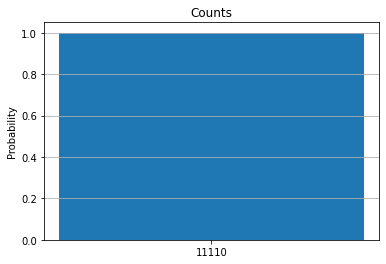

In [140]:
plot_histogram(counts=counts)


## Teleportation Algorithm

In [151]:
tp_program = ql.Program("teleportation", platform=platform, qubit_count=3)
tp_kernel = ql.Kernel("tp-kernel", platform=platform, qubit_count=3)

# prepare state that will be sent, ie |1>
tp_kernel.x(0)

# create bell state for Alice and Bob
tp_kernel.hadamard(1)
tp_kernel.cnot(1, 2)

# bell basis measurement by Alice
tp_kernel.cnot(0, 1)
tp_kernel.hadamard(0)

# Bob's state translation
tp_kernel.cnot(1, 2)
tp_kernel.cz(0, 2)

tp_kernel.measure(0)
tp_kernel.measure(1)
tp_kernel.measure(2)

tp_program.add_kernel(tp_kernel)
tp_program.compile()


In [152]:
counts = simulate(program=tp_program, shots=1024)


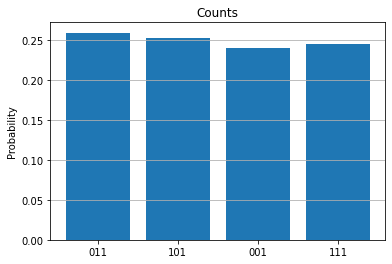

In [153]:
plot_histogram(counts)


In [154]:
counts = simulate(program=tp_program, measured=[2], shots=1024)


In [155]:
counts


{'1': 1024}